In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypalettes import load_cmap
from pyfonts import load_font

Followed [this](https://towardsdatascience.com/create-eye-catching-radial-bar-charts-with-matplotlib-fd03ff732048/) tutorial by Andy McDonald.

In [99]:
gutenberg_authors = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-06-03/gutenberg_authors.csv')
gutenberg_languages = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-06-03/gutenberg_languages.csv')
gutenberg_metadata = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-06-03/gutenberg_metadata.csv')
gutenberg_subjects = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-06-03/gutenberg_subjects.csv')

In [100]:
total_authors = gutenberg_authors["gutenberg_author_id"].nunique()
total_books = gutenberg_metadata["gutenberg_id"].nunique()
total_languages = gutenberg_languages["language"].nunique()

# Bookshelf

In [101]:
gutenberg_metadata.head(1)

,gutenberg_id,title,author,gutenberg_author_id,language,gutenberg_bookshelf,rights,has_text
0,1,The Declaration of Independence of the United ...,"Jefferson, Thomas",1638.0,en,Politics/American Revolutionary War/United Sta...,Public domain in the USA.,True


In [102]:
mbs_raw = gutenberg_metadata["gutenberg_bookshelf"].str.replace('Browsing: ', '', regex=True).str.split(pat="/", expand=True)

In [103]:
mbs_raw.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Politics,American Revolutionary War,United States Law,History - American,History - Warfare,Politics,None,None,None,None,None,None,None


In [104]:
mbs_raw = mbs_raw.drop([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], axis=1)
mbs_raw.rename(columns={0: 'main_shelf'}, inplace=True)

In [105]:
mbs = mbs_raw["main_shelf"].str.replace('Reading', '', regex=True).str.split(pat="-", expand=True)

In [106]:
mbs= mbs.drop([1, 2], axis=1)
mbs.rename(columns={0: 'main_shelf'}, inplace=True)
mbs["main_shelf"] = mbs["main_shelf"].fillna("uncategorized")

In [107]:
df1 = pd.concat([gutenberg_metadata, mbs], axis=1)

In [108]:
df2 = df1.groupby('main_shelf', observed=True)['gutenberg_id'].nunique().reset_index(name='count').sort_values(by="count")

In [109]:
df2['cat'] = np.where(df2['count'] > 3000, df2['main_shelf'], 'Other') 

In [110]:
df2=df2.groupby("cat", observed=True)["count"].sum().reset_index().sort_values(by="count")

In [111]:
shelf_df = df2.copy()
shelf_df

,cat,count
0,Biographies,3053
1,Children & Young Adult,6209
3,History,10986
4,Literature,11368
2,Culture,12498
5,Other,31872


# Language

In [112]:
gutenberg_languages.head(1)

,gutenberg_id,language,total_languages
0,1,en,1


In [113]:
df3 = gutenberg_languages.groupby('language', observed=True)['gutenberg_id'].nunique().reset_index(name='count').sort_values(by="count")

In [114]:
total2 =df3["count"].sum()
total2

np.int64(76205)

In [115]:
df3['cat'] = np.where(df3['count'] > 1050, df3['language'], 'Other') 

In [116]:
df3=df3.groupby("cat", observed=True)["count"].sum().reset_index().sort_values(by="count")

In [117]:
lan_dict = {"en": "English", "fr": "French", "fi": "Finnish", "de": "German", "it":"Italian", "Other": "Other"}
df3["cat"] = df3["cat"].map(lan_dict)

In [118]:
lan_df = df3.copy()
lan_df

,cat,count
5,Italian,1056
1,German,2324
3,Finnish,3313
4,French,3973
0,Other,4846
2,English,60693


# Time period

In [119]:
gutenberg_authors.head(1)

,gutenberg_author_id,author,alias,birthdate,deathdate,wikipedia,aliases
0,1,United States,U.S.A.,NaN,NaN,https://en.wikipedia.org/wiki/United_States,U.S.A.


In [120]:
df4 = pd.merge(gutenberg_authors, gutenberg_metadata, how="right", on="gutenberg_author_id", suffixes=(' ', '_meta'))

In [121]:
df4 = df4.drop_duplicates(subset=['gutenberg_id'], keep='first')

In [122]:
df4 = df4[["gutenberg_id", "deathdate"]]

In [123]:
df4 = df4.copy()
df4["deathdate"] = df4["deathdate"].fillna(2222.0)

In [124]:
df4['cat'] = pd.cut(df4.deathdate, bins=[-1150, 500, 1500, 1800, 1900, 2000, 2222],  
                           labels=['Antiquity', 'Middle Age', 'Discoveries', '19th century', '20th century', 'Unknown']) 

In [125]:
df4 = df4.groupby('cat', observed=True)['gutenberg_id'].nunique().reset_index(name='count').sort_values(by="count")

In [126]:
time_df = df4.copy()
time_df

,cat,count
1,Middle Age,318
0,Antiquity,499
2,Discoveries,2993
3,19th century,15210
5,Unknown,18430
4,20th century,38536


In [127]:
special_elite = load_font(
    font_url="https://github.com/google/fonts/blob/main/apache/specialelite/SpecialElite-Regular.ttf?raw=true"
)

In [128]:
cmap = load_cmap("Arches")

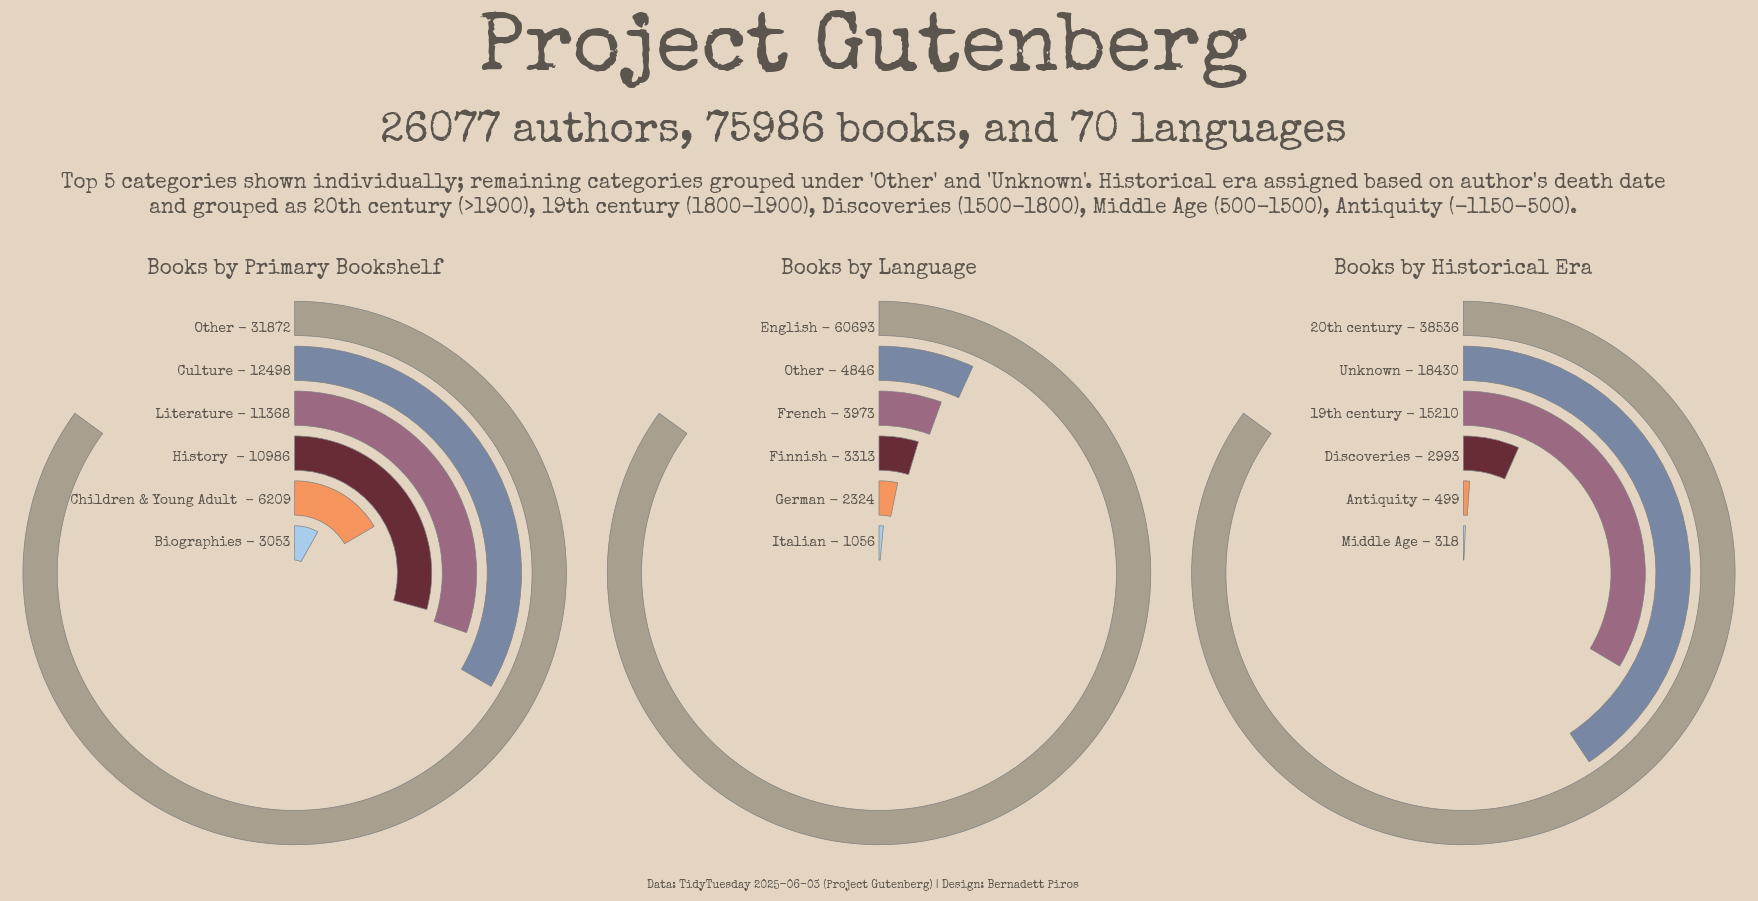

In [137]:
titles = ["Books by Primary Bookshelf", "Books by Language", "Books by Historical Era"]
dfs = [shelf_df, lan_df, time_df]

def plot_polar_subplots(dfs):
    fig, axes = plt.subplots(1, 3, subplot_kw={'polar': True}, figsize=(18, 9))
    
    for i in range(len(dfs)):
        df = dfs[i]
        ax = axes[i]
        data_len = len(df)
        max_value_full_ring = max(df['count'])        
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)        
        ax.grid(False)
        ax.set_facecolor("#e3d5c2")
        ax.spines['polar'].set_visible(False)
        ax.tick_params(axis='both', left=False, bottom=False, 
                           labelbottom=False, labelleft=True)

        # Calculate angles for bars
        angles = np.linspace(0, 2 * np.pi, data_len, endpoint=False).tolist()

        ax.set_title(titles[i], alpha=0.6, font=special_elite, size=15, pad=10)

        # Plot bars and text
        for i, (cats, counts), in enumerate(zip(df['cat'], df['count'])):
            theta = angles[i]
            radius = counts * 1.7 * np.pi / max_value_full_ring            
            ax.barh(theta, radius, color=cmap.colors[i], edgecolor='grey', lw=0.5)            

            text_labels = [f'   {x} - {v} ' for x, v in zip(list(df['cat']), list(df['count']))]

            ax.set_rgrids([0, 1, 2, 3, 4, 5], 
                    labels=text_labels, 
                    angle=0, 
                    fontsize=8, font=special_elite,
                    color='black', alpha=0.6, va='center')
            
            # Text label alignment
            for label in ax.get_yaxis().get_ticklabels():
                label.set_horizontalalignment('right')           
            
    fig.set_facecolor('#e3d5c2')

    fig.text(0.5, 1.06, "Project Gutenberg", font=special_elite, alpha=0.6, size=60, ha="center")
    fig.text(0.5, 0.98, s=f"{total_authors} authors, {total_books} books, and {total_languages} languages", alpha=0.6, font=special_elite, size=30, ha="center")
    fig.text(0.5, 0.9, "Top 5 categories shown individually; remaining categories grouped under 'Other' and 'Unknown'. Historical era assigned based on author's death date\nand grouped as 20th century (>1900), 19th century (1800-1900), Discoveries (1500-1800), Middle Age (500-1500), Antiquity (-1150-500).",
             font=special_elite, alpha=0.6, size=15, ha="center")
    fig.text(0.5, 0.15, "Data: TidyTuesday 2025-06-03 (Project Gutenberg) | Design: Bernadett Piros", font=special_elite, fontsize=8, alpha=0.6, ha="center")
    
    plt.tight_layout()
    plt.show()

    #fig.savefig("2025-06-03.png", bbox_inches='tight', pad_inches=0.2)

plot_polar_subplots([shelf_df, lan_df, time_df])